<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/collaborative_filtering_%EC%97%B0%EC%8A%B5(8)_%EC%9E%A0%EC%9E%AC%EC%9A%94%EC%9D%B8%EA%B8%B0%EB%B0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

잠재요인기반 협업 필터링  

In [3]:
# !pip install datasets

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset

## 데이터로드 및 전처리

In [5]:
# json 파일을불러와서 df 로 저장
df = pd.read_json('reviews_240429.json', lines=True)
df.head()

,User Name,Rating,URL,Review Text,Place Name,User Id,Place Id
0,배정석,1,https://place.map.kakao.com/8229674,현장 공원 주차 관리인들의 마인드가 갑인 미친 조직\n\n[Web발신]\n안녕하십니...,길동생태공원,1685,34
1,김태운,5,https://place.map.kakao.com/8229674,"여러 자연생물이 많고,도장을 찍을 수도 있어서 아이들이 좋아하네요",길동생태공원,1166,34
2,겜린이,3,https://place.map.kakao.com/8229674,자연이 날뛰는 공간이네요 ㅎㅎ,길동생태공원,936,34
3,Babar Usman Kahlon,4,https://place.map.kakao.com/8229674,Kahlon King at Gildong Eco Park. The environme...,길동생태공원,82,34
4,wj LEE,1,https://place.map.kakao.com/8229674,짜증나게 미리 예약...,길동생태공원,757,34


In [61]:
df = df.copy()

In [62]:
df.tail()

,User Name,Rating,URL,Review Text,Place Name,User Id,Place Id
4470,cxncnrienf288r,1,https://place.map.kakao.com/729961917,컴플레인은 중랑구청 도서관 담당하는 부서에 하면 직빵입니다. 여기다 하면 제식구 감...,중랑상봉도서관,482,159
4471,soo,5,https://place.map.kakao.com/729961917,,중랑상봉도서관,717,159
4472,ندى,5,https://place.map.kakao.com/729961917,새 건물 새 책 좋아요!,중랑상봉도서관,785,159
4473,🐰,1,https://place.map.kakao.com/729961917,도서관 문 연지 얼마 안됐을때 도서관 오후 8시에 닫는 걸로 공지되어있던데 7시 4...,중랑상봉도서관,2978,159
4474,Leeh,5,https://place.map.kakao.com/729961917,,중랑상봉도서관,272,159


In [63]:
df.shape

(4475, 7)

# 사용자 평점데이터 만들기

In [64]:
user_rating = df[['User Id', 'Place Id', 'Rating']]


user_rating.tail()


,User Id,Place Id,Rating
4470,482,159,1
4471,717,159,5
4472,785,159,5
4473,2978,159,1
4474,272,159,5


In [65]:
user_rating.to_csv(f'user_rating_240429.csv', index=False, encoding='utf-8')

아이템-특성 데이터 만들기

In [66]:
# place_id, type, place_name만 추출
item_feature = df[['Place Id', 'Place Name']]
# 중복 삭제
item_feature = item_feature.drop_duplicates()
# 인덱스 초기화
item_feature = item_feature.reset_index(drop=True)
item_feature.tail()

,Place Id,Place Name
173,3,가온도서관
174,78,서울도서관
175,36,꿈꾸는 도서관
176,158,중랑구립정보도서관
177,159,중랑상봉도서관


In [148]:
# csv 파일로 저장
item_feature.to_csv(f'item_feature_240429.csv', index=False, encoding='utf-8')

# 추천시스템구현

데이터확인

In [67]:
user_rating.shape

(4475, 3)

In [68]:
item_feature.shape

(178, 2)

In [69]:
user_place_data = pd.merge(user_rating, item_feature, on='Place Id')
user_place_data.head()

,User Id,Place Id,Rating,Place Name
0,1685,34,1,길동생태공원
1,1166,34,5,길동생태공원
2,936,34,3,길동생태공원
3,82,34,4,길동생태공원
4,757,34,1,길동생태공원


In [70]:
user_place_data.shape # (4475, 4)

(4475, 4)

In [149]:
# csv 파일로 저장
user_place_data.to_csv(f'user_place_data_240429.csv', index=False, encoding='utf-8')

In [71]:
# 사용자-평점데이터로 변경
df_user_place_ratings = user_place_data.pivot_table(index='User Id', columns='Place Id', values='Rating')
df_user_place_ratings.head()

Place Id,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
User Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# NaN 값에 0 집어 넣기
df_user_place_ratings = df_user_place_ratings.fillna(0)
df_user_place_ratings.head()

Place Id,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
User Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


사용자-장소 pivot table을 만들었다.

이제 아래와 같이 데이터를 조금 변경해서 진행하겠습니다.

pivot table을 matrix로 변환
np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균을 구함
1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [73]:
print(df_user_place_ratings.columns.dtype)

int64


In [74]:
print(df_user_place_ratings.columns.dtype)

int64


In [75]:
df_user_place_ratings.columns = df_user_place_ratings.columns.astype(str)

In [76]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것
df_user_place_ratings.columns = df_user_place_ratings.columns.str.strip() # 컬럼명에 화이트스페이스 지우기
matrix = df_user_place_ratings.values #as_matrix function은 depricated.
matrix
# # user_ratings_mean은 사용자의 평균 평점
user_ratings_mean = np.mean(matrix, axis = 1)

# # R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [77]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
matrix.shape # (3, 1663)

(3009, 178)

In [79]:
user_ratings_mean.shape

(3009,)

In [80]:
matrix_user_mean.shape

(3009, 178)

In [81]:
pd.DataFrame(matrix_user_mean, columns = df_user_place_ratings.columns).head()

Place Id,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
0,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,...,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090
1,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,...,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090
2,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,...,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090,-0.028090
3,4.747191,-0.252809,4.747191,-0.252809,-0.252809,-0.252809,-0.252809,-0.252809,-0.252809,-0.252809,...,-0.252809,-0.252809,-0.252809,-0.252809,-0.252809,-0.252809,4.747191,-0.252809,-0.252809,-0.252809
4,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,...,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180,-0.056180


여기까지 진행하면 초기에 만들었던 user-place pivot table 값이 matrix_user_mean 로 변경된것임.

사용자 x명이 y개의 영화에 대해 평점을 매긴 값이 존재
사용자 x명의 각각 평균 평점을 구해서
사용자 x명의 y개의 장소에 대해 평점을 조금 변경 -> 1에서 구한 값 - 2에서 구한 값
이제 SVD를 이용해 Matrix Factorization을 진행

아까는 scikit learn을 이용해 TruncatedSVD를 이용했는데요. 이번에는 scipy를 이용해 Truncated SVD를 구해봅니다.

이 둘의 차이점은 scikit learn에서 제공해주는 TruncatedSVD는 U, Sigma, Vt 반환 값을 제공하지 않습니다.
하지만, Scipy를 이용하면 이 반환값들을 제공받을 수 있죠.

Scipy에서 제공해주는 Truncate SVD는 scipy.sparse.linalg.svds를 이용하면 됩니다. 저는 이것을 이용했습니다.

이렇게 사용하면 반환값이 U 행렬, Sigma 행렬, V 전치 행렬(Vt)가 나오게 됩니다.

In [82]:

# scipy에서 제공해주는 svd.
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [83]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)
# 현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태입니다.
# 즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 합니다.

(3009, 12)
(12,)
(12, 178)


In [84]:

sigma = np.diag(sigma)

In [85]:
sigma.shape

(12, 12)

In [86]:

sigma[0]

array([38.56969885,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [87]:
sigma[1]

array([ 0.       , 43.0736618,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ])

이렇게 대칭 행렬로 변환이 되었습니다.

현재 까지 상황을 정리하면 아래와 같습니다.

원본 user-movie 평점 행렬이 있었음
이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환
자! 이제 여기서 matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.
이제, 다시 원본 행렬로 복구시켜야겠죠?

원본 행렬로 복구시키는 방법은 아래와 같습니다.

U, Sigma, Vt의 내적을 수행
즉, np.dot(np.dot(U, sigma), Vt)를 수행하면 됩니다.

그리고 아까 사용자 평균을 빼주었으니 여기서는 더해줍니다.

In [98]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다.
# 거기에 + 사용자 평균 rating을 적용한다.
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [135]:
# 값을 1과 5사이로 cliping
svd_user_predicted_ratings = np.clip(svd_user_predicted_ratings, 1, 5)

In [136]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_place_ratings.columns)
df_svd_preds.head()

Place Id,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [134]:
df_svd_preds.shape

(3009, 178)


자! 이제 함수를 하나 만듭니다. 이 함수의 기능은 아래와 같습니다.

인자로 사용자 아이디, 영화 정보 테이블, 평점 테이블 등을 받음
사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬
사용자가 본 데이터를 제외
사용자가 안 본 영화에서 평점이 높은 것을 추천

In [137]:
# def recommend_places(df_svd_preds, user_id, ori_places_df, ori_ratings_df, num_recommendations=5):

df_svd_preds = df_svd_preds
user_id = 55
ori_places_df = item_feature
ori_ratings_df = user_rating
num_recommendations = 5

# # 사용자의 예측 평점이 높은 순으로 정렬된 데이터
user_row_number = user_id
sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
sorted_user_predictions
sorted_user_predictions = pd.DataFrame(sorted_user_predictions.reset_index())
sorted_user_predictions.columns = ['Place Id', 'Predict Rating']

sorted_user_predictions['Place Id'] = sorted_user_predictions['Place Id'].astype('int64')
sorted_user_predictions

# # 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
user_data = ori_ratings_df[ori_ratings_df['User Id'] == user_id]
# # 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
user_data = ori_ratings_df[ori_ratings_df['User Id'] == user_id]

user_data
# # (가본장소)추출된 데이터와 원본 장소 데이터를 합침
user_history = user_data.merge(ori_places_df, on='Place Id').sort_values(['Rating'], ascending=False)

# # 사용자가 평가하지 않은 장소를 추천 대상으로 설정
recommendations = ori_places_df[~ori_places_df['Place Id'].isin(user_history['Place Id'])]

# # 'place_id'를 int64로 변경
recommendations['Place Id'] = recommendations['Place Id'].astype('int64')

# # sorted_user_predictions과 recommendations를 합침
recommendations = pd.merge(sorted_user_predictions,recommendations, on='Place Id')

# # 정렬해서 리턴
recommendations = recommendations.sort_values(['Predict Rating'], ascending=False).head(num_recommendations)




In [138]:
sorted_user_predictions

,Place Id,Predict Rating
0,63,4.933389
1,0,1.000000
2,133,1.000000
3,114,1.000000
4,115,1.000000
...,...,...
173,61,1.000000
174,62,1.000000
175,64,1.000000
176,65,1.000000


In [139]:
user_data

,User Id,Place Id,Rating
3840,55,25,3
3892,55,87,3
4368,55,103,3


In [140]:
# sorted_user_predictions과 user_data merge해서 예측평점과 비교
evals = pd.merge(sorted_user_predictions, user_data, on='Place Id')
evals

,Place Id,Predict Rating,User Id,Rating
0,103,1.0,55,3
1,25,1.0,55,3
2,87,1.0,55,3


In [141]:
recommendations

,Place Id,Predict Rating,Place Name
0,63,4.933389,보라매근린공원
120,9,1.000000,강동구립암사도서관
112,10,1.000000,강동구립해공도서관
113,2,1.000000,가양도서관
114,3,1.000000,가온도서관


# 성능평가

In [142]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = train_test_split(matrix_user_mean, test_size=0.2, random_state=42)
train_user_ratings_mean = np.mean(train_data, axis=1)

min(train_data.shape)


178

In [143]:
# k 값의 범위 설정
ks = [i for i in range(1,min(train_data.shape))]

metrics = []
#  `k` must be an integer satisfying `0 < k < min(A.shape)`.
# k 값에 따른 SVD 수행 및 평가 지표 계산
for k in ks:
    U, sigma, Vt = svds(train_data, k=k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean[:train_data.shape[0]].reshape(-1, 1)

    # 테스트 데이터의 예측
    predicted_ratings = all_user_predicted_ratings[test_data.nonzero()]
    actual_ratings = test_data[test_data.nonzero()]

    # 평가 지표 계산
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    correlation = np.corrcoef(actual_ratings, predicted_ratings)[0, 1]
    threshold = 3.5
    accuracy = np.mean((actual_ratings >= threshold) == (predicted_ratings >= threshold))
    precision = np.sum((actual_ratings >= threshold) & (predicted_ratings >= threshold)) / np.sum(predicted_ratings >= threshold)
    recall = np.sum((actual_ratings >= threshold) & (predicted_ratings >= threshold)) / np.sum(actual_ratings >= threshold)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # 저장
    metrics.append((k, mse, mae, correlation, accuracy, precision, recall, f1_score))



# 결과 출력
# mse
for metric in metrics:
    k, mse, mae, correlation, accuracy, precision, recall, f1_score = metric
    print(f'k={k}: MSE={mse:.4f}, MAE={mae:.4f}, Correlation={correlation:.4f}, Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}')


k=1: MSE=0.1839, MAE=0.1103, Correlation=0.0475, Accuracy=0.9926, Precision=0.1364, Recall=0.0164, F1 Score=0.0293
k=2: MSE=0.1925, MAE=0.1098, Correlation=0.0561, Accuracy=0.9922, Precision=0.1241, Recall=0.0233, F1 Score=0.0392
k=3: MSE=0.2021, MAE=0.1099, Correlation=0.0519, Accuracy=0.9918, Precision=0.1044, Recall=0.0260, F1 Score=0.0416
k=4: MSE=0.2074, MAE=0.1116, Correlation=0.0519, Accuracy=0.9918, Precision=0.1022, Recall=0.0260, F1 Score=0.0414
k=5: MSE=0.2132, MAE=0.1127, Correlation=0.0490, Accuracy=0.9915, Precision=0.0926, Recall=0.0274, F1 Score=0.0422
k=6: MSE=0.2182, MAE=0.1128, Correlation=0.0482, Accuracy=0.9913, Precision=0.0864, Recall=0.0287, F1 Score=0.0431
k=7: MSE=0.2228, MAE=0.1133, Correlation=0.0446, Accuracy=0.9911, Precision=0.0812, Recall=0.0301, F1 Score=0.0439
k=8: MSE=0.2262, MAE=0.1143, Correlation=0.0437, Accuracy=0.9910, Precision=0.0780, Recall=0.0301, F1 Score=0.0434
k=9: MSE=0.2297, MAE=0.1151, Correlation=0.0428, Accuracy=0.9908, Precision=0.07

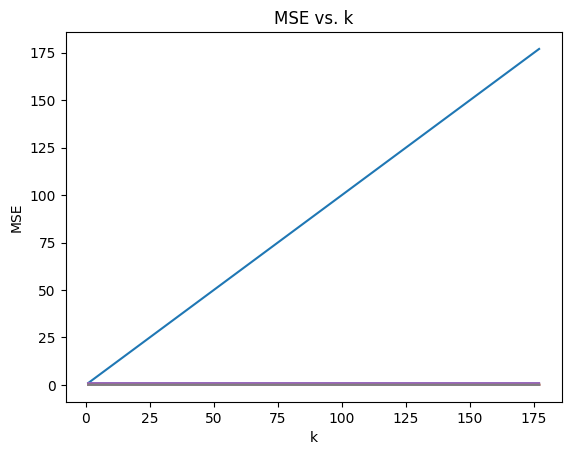

In [124]:
# k값에 따른 시각화
plt.plot(ks, metrics)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('MSE vs. k')
plt.show()

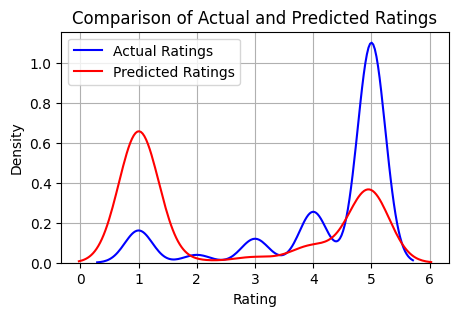

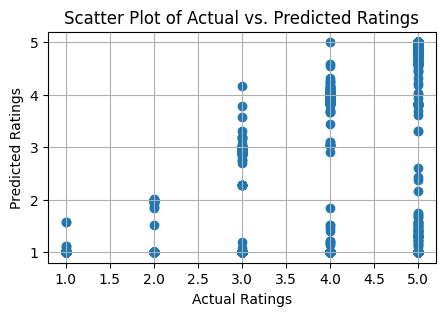

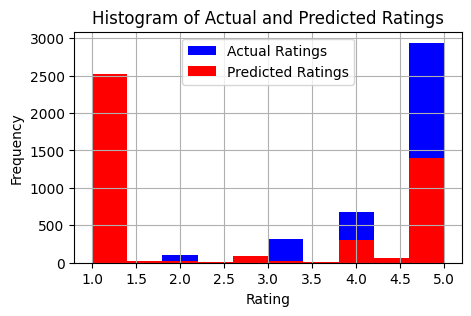

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터에서 평점이 0인 데이터 제외
non_zero_indices = df_user_place_ratings.values.flatten() != 0
actual_ratings = df_user_place_ratings.values.flatten()[non_zero_indices]
predicted_ratings = df_svd_preds.values.flatten()[non_zero_indices]

# 실제 평점과 예측 평점의 분포 비교
plt.figure(figsize=(5, 3))
sns.kdeplot(actual_ratings, bw_adjust=1, label='Actual Ratings', color='blue')
sns.kdeplot(predicted_ratings, bw_adjust=1, label='Predicted Ratings', color='red')
plt.title('Comparison of Actual and Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 실제 평점과 예측 평점의 산점도
plt.figure(figsize=(5, 3))
plt.scatter(actual_ratings, predicted_ratings, alpha=1)
plt.title('Scatter Plot of Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()

# 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(actual_ratings, bins=10, alpha=1, label='Actual Ratings', color='blue')
plt.hist(predicted_ratings, bins=10, alpha=1, label='Predicted Ratings', color='red')
plt.title('Histogram of Actual and Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

